# DeepFish processig

Paper: https://arxiv.org/abs/2008.12603 . Download: https://www.kaggle.com/datasets/vencerlanz09/deep-fish-object-detection?resource=download

What data we have is discussed in Emilia's master.

The orignal dataset has 3596/909 images + 2012 background images = 6517 images. In my split: first 30% of the background images are put in the training set and 70% in the validation set. After this  

### unzip



In [1]:
# unzip

from pathlib import Path
import zipfile

zip_path = Path("archive.zip")
out_dir  = Path("processed")
out_dir.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    for member in z.infolist():
        target = out_dir / member.filename
        if target.exists():
            continue
        z.extract(member, out_dir)



### To right format

In [1]:
from pathlib import Path
import shutil, random

# -------- CONFIG --------
SRC_ROOT = Path("processed/Deepfish")
NEG_DIR  = SRC_ROOT / "Nagative_samples"   # <-- exact name from your tree
OUT_ROOT = Path("processed")
NEG_VAL_FRAC = 0.3
NEG_USE_FRAC = 0.4   # <-- use only 40% of negatives
SEED = 0
MODE = "copy"   # "copy" | "move" | "symlink"
# ------------------------

IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}

out_img_train = OUT_ROOT / "images" / "train"
out_lab_train = OUT_ROOT / "labels" / "train"
out_img_val   = OUT_ROOT / "images" / "val"
out_lab_val   = OUT_ROOT / "labels" / "val"
for p in [out_img_train, out_lab_train, out_img_val, out_lab_val]:
    p.mkdir(parents=True, exist_ok=True)

def link_or_copy(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    if MODE == "copy":
        shutil.copy2(src, dst)
    elif MODE == "move":
        shutil.move(str(src), str(dst))
    elif MODE == "symlink":
        if dst.exists():
            dst.unlink()
        dst.symlink_to(src.resolve())
    else:
        raise ValueError(f"Unknown MODE={MODE}")

def is_image(p: Path) -> bool:
    return p.is_file() and p.suffix.lower() in IMG_EXTS

def unique_name(img_path: Path, tag: str, split: str) -> str:
    rel = img_path.relative_to(SRC_ROOT)
    cleaned = [x for x in rel.parts[:-1] if x not in ("train", "valid", "Nagative_samples")]
    prefix = "_".join(cleaned)
    return f"{tag}_{split}_{prefix}__{img_path.name}" if prefix else f"{tag}_{split}__{img_path.name}"

print("SRC_ROOT:", SRC_ROOT.resolve())
print("NEG_DIR exists:", NEG_DIR.exists(), "->", NEG_DIR)

# 1) Positives: train -> train, valid -> val (skip negatives)
pos = {"train": 0, "val": 0}
for img in SRC_ROOT.rglob("*"):
    if not is_image(img):
        continue
    if NEG_DIR in img.parents:
        continue

    parts = set(img.parts)
    split = "train" if "train" in parts else ("val" if "valid" in parts else None)
    if split is None:
        continue

    new_img = unique_name(img, tag="pos", split=split)
    dst_img = (out_img_train if split == "train" else out_img_val) / new_img
    dst_lab = (out_lab_train if split == "train" else out_lab_val) / Path(new_img).with_suffix(".txt").name

    link_or_copy(img, dst_img)

    lab = img.with_suffix(".txt")
    if lab.exists():
        link_or_copy(lab, dst_lab)
    else:
        dst_lab.write_text("")  # safety

    pos[split] += 1

# 2) Negatives: take only 50% first, then split into train/val
neg_imgs_all = [p for p in NEG_DIR.rglob("*") if is_image(p)]

random.seed(SEED)
random.shuffle(neg_imgs_all)

n_use = int(len(neg_imgs_all) * NEG_USE_FRAC)
neg_imgs = neg_imgs_all[:n_use]   # <-- only keep 50%

n_val = int(len(neg_imgs) * NEG_VAL_FRAC)
neg_val = neg_imgs[:n_val]
neg_train = neg_imgs[n_val:]

neg = {"train": 0, "val": 0}

def add_neg(img_path: Path, split: str):
    new_img = unique_name(img_path, tag="neg", split=split)
    dst_img = (out_img_train if split == "train" else out_img_val) / new_img
    dst_lab = (out_lab_train if split == "train" else out_lab_val) / Path(new_img).with_suffix(".txt").name

    link_or_copy(img_path, dst_img)
    lab = img_path.with_suffix(".txt")
    if lab.exists():
        link_or_copy(lab, dst_lab)
    else:
        dst_lab.write_text("")  # empty label file = negative
    neg[split] += 1

for p in neg_train:
    add_neg(p, "train")
for p in neg_val:
    add_neg(p, "val")

print("Done.")
print("Positives:", pos)
print("Negatives used:", len(neg_imgs), "of", len(neg_imgs_all))
print("Negatives:", neg)
print("Train images:", len(list(out_img_train.glob("*"))), "Train labels:", len(list(out_lab_train.glob("*.txt"))))
print("Val images:  ", len(list(out_img_val.glob("*"))),   "Val labels:  ", len(list(out_lab_val.glob("*.txt"))))


SRC_ROOT: /cluster/home/henrban/aquaculture-perception/data-processing/vision/DeepFish/processed/Deepfish
NEG_DIR exists: True -> processed/Deepfish/Nagative_samples
Done.
Positives: {'train': 3596, 'val': 909}
Negatives used: 804 of 2012
Negatives: {'train': 563, 'val': 241}
Train images: 4159 Train labels: 4159
Val images:   1150 Val labels:   1150


# Making train/val/test split

In [2]:
from pathlib import Path
import random
import re
import shutil

# ---------------- CONFIG ----------------
ROOT = Path("processed")       # contains images/ and labels/
VAL_FRAC = 0.12                # take ~12% of current TRAIN -> new VAL
SEED = 0
DRY_RUN = False                # True = print what would happen, do nothing
GROUP_WISE = True              # True = split by ID groups (recommended)
# --------------------------------------

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

img_train = ROOT / "images" / "train"
lab_train = ROOT / "labels" / "train"
img_val   = ROOT / "images" / "val"
lab_val   = ROOT / "labels" / "val"
img_test  = ROOT / "images" / "test"
lab_test  = ROOT / "labels" / "test"

def list_images(folder: Path):
    return sorted([p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS])

def move_path(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    if DRY_RUN:
        return
    shutil.move(str(src), str(dst))

def ensure_dir(p: Path):
    if DRY_RUN:
        return
    p.mkdir(parents=True, exist_ok=True)

def get_group_id(filename: str) -> str:
    """
    Your generated names look like:
      pos_train_7117__XXXX.jpg
      neg_train_9907__YYYY.jpg
    We extract the '7117' or '9907' part robustly.
    """
    left = filename.split("__", 1)[0]  # "pos_train_7117"
    # remove leading pos/neg + split tag
    left = re.sub(r"^(pos|neg)_(train|val|test)_", "", left)
    left = re.sub(r"^(pos|neg)_", "", left)  # fallback
    return left or "unknown"

def sanity_count(split: str):
    imgs = list_images(ROOT / "images" / split)
    labs = sorted([p for p in (ROOT / "labels" / split).glob("*.txt")]) if (ROOT / "labels" / split).exists() else []
    return len(imgs), len(labs)

# ---------------- Step 1: val -> test ----------------
if img_val.exists() or lab_val.exists():
    if img_test.exists() or lab_test.exists():
        raise RuntimeError("processed/images/test or processed/labels/test already exists. Remove/rename it first.")

    print("Renaming current VAL -> TEST ...")
    if img_val.exists():
        move_path(img_val, img_test)
    if lab_val.exists():
        move_path(lab_val, lab_test)
else:
    print("No existing VAL found; skipping val->test rename.")

# Ensure fresh val folders exist
ensure_dir(img_val)
ensure_dir(lab_val)

# ---------------- Step 2: choose new val from train ----------------
train_imgs = list_images(img_train)
n_train = len(train_imgs)
if n_train == 0:
    raise RuntimeError(f"No train images found in {img_train}")

target_val = max(1, int(round(VAL_FRAC * n_train)))
print(f"Current TRAIN images: {n_train}")
print(f"Target new VAL from TRAIN: ~{target_val} images ({VAL_FRAC*100:.1f}%)")

random.seed(SEED)

selected_imgs = []

if GROUP_WISE:
    # group-wise selection to reduce leakage
    groups = {}
    for p in train_imgs:
        gid = get_group_id(p.name)
        groups.setdefault(gid, []).append(p)

    group_keys = list(groups.keys())
    random.shuffle(group_keys)

    picked = 0
    for gid in group_keys:
        imgs = groups[gid]
        if picked >= target_val:
            break
        selected_imgs.extend(imgs)
        picked += len(imgs)

    print(f"Group-wise: picked {len(selected_imgs)} images from {len(set(get_group_id(p.name) for p in selected_imgs))} groups.")
else:
    # per-image random sample
    selected_imgs = random.sample(train_imgs, k=min(target_val, n_train))
    print(f"Image-wise: picked {len(selected_imgs)} images.")

# ---------------- Step 3: move selected train -> val (image + label) ----------------
moved = 0
missing_labels = 0

for img_path in selected_imgs:
    dst_img = img_val / img_path.name
    src_lab = lab_train / (img_path.stem + ".txt")
    dst_lab = lab_val / (img_path.stem + ".txt")

    # move image
    move_path(img_path, dst_img)

    # move label (or create empty if missing)
    if src_lab.exists():
        move_path(src_lab, dst_lab)
    else:
        missing_labels += 1
        if not DRY_RUN:
            dst_lab.write_text("")

    moved += 1

print("Done moving train -> val.")
print("Moved images:", moved)
print("Missing labels (created empty):", missing_labels)

# ---------------- Final sanity summary ----------------
for split in ("train", "val", "test"):
    imgs_n, labs_n = sanity_count(split)
    print(f"{split:5s}: images={imgs_n:5d}, labels={labs_n:5d}")


Renaming current VAL -> TEST ...
Current TRAIN images: 4159
Target new VAL from TRAIN: ~499 images (12.0%)
Group-wise: picked 733 images from 5 groups.
Done moving train -> val.
Moved images: 733
Missing labels (created empty): 0
train: images= 3426, labels= 3426
val  : images=  733, labels=  733
test : images= 1150, labels= 1150


# Yaml setup


In [3]:
from pathlib import Path


DeepFish_ROOT = Path.cwd()             

DATA = DeepFish_ROOT / "processed" 
IMAGES_TRAIN = DATA / "images" / "train"
IMAGES_VAL = DATA / "images" / "val"
IMAGES_TEST   = DATA / "images" / "test"        # or use a dedicated val split if you have one

dataset_yaml = f"""
train: {IMAGES_TRAIN.as_posix()}
val:   {IMAGES_VAL.as_posix()}
test:  {IMAGES_TEST.as_posix()}


names:
  - fish
"""
(DeepFish_ROOT / "DeepFish.yaml").write_text(dataset_yaml)
print("Wrote:", DeepFish_ROOT / "DeepFish.yaml")


Wrote: /cluster/home/henrban/aquaculture-perception/data-processing/vision/DeepFish/DeepFish.yaml


# Dataset sumamry


In [4]:
from pathlib import Path
import sys

DATA_PROCESSING_ROOT = Path.cwd().resolve().parents[1]  # your working solution
sys.path.insert(0, str(DATA_PROCESSING_ROOT))

from utils.yolo_dataset_summary import count_from_yaml

counts = count_from_yaml("DeepFish.yaml")
# print(counts)
for split in ["train", "val", "test", "total"]:
    if split in counts:
        print(f"{split:5s}  images={counts[split]['images']:6d}  instances={counts[split]['instances']:8d}")


train  images=  3426  instances=    9674
val    images=   733  instances=    2760
test   images=  1150  instances=    3029
total  images=  5309  instances=   15463


In [6]:
from pathlib import Path

ROOT = Path("processed/images")
splits = ["train", "val", "test"]

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def count_negatives(split: str):
    d = ROOT / split
    imgs = [p for p in d.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
    n_total = len(imgs)
    n_neg = sum(p.name.startswith("neg_") for p in imgs)
    n_pos = n_total - n_neg
    return n_total, n_pos, n_neg

for s in splits:
    if (ROOT / s).exists():
        total, pos, neg = count_negatives(s)
        print(f"{s:5s}  total={total:5d}  pos={pos:5d}  neg={neg:5d}  neg%={(neg/total*100 if total else 0):5.1f}%")
    else:
        print(f"{s:5s}  (missing)")


train  total= 3426  pos= 2949  neg=  477  neg%= 13.9%
val    total=  733  pos=  647  neg=   86  neg%= 11.7%
test   total= 1150  pos=  909  neg=  241  neg%= 21.0%


# Dataset examples

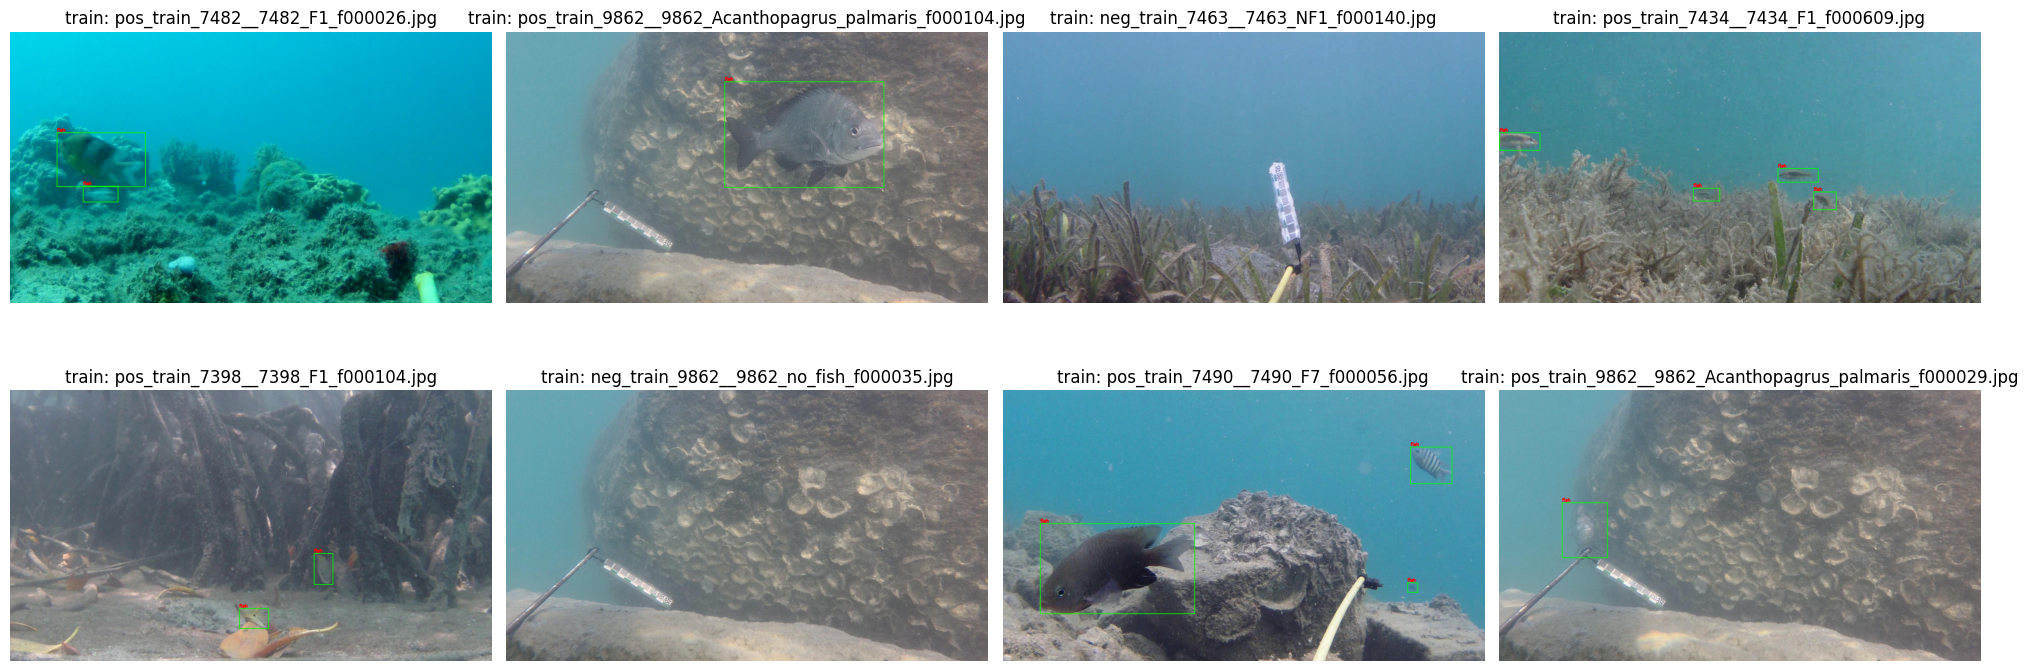

In [15]:
from pathlib import Path
import sys

DATA_PROCESSING_ROOT = Path.cwd().resolve().parents[1]  # RUOD -> vision -> data-processing
sys.path.insert(0, str(DATA_PROCESSING_ROOT))


from utils.yolo_viz import load_yolo_dataset_yaml, show_random_labeled_images

ds = load_yolo_dataset_yaml("DeepFish.yaml")  # yaml is next to the notebook

split = "train"  # train / val / test
img_dir = {"train": ds.train, "val": ds.val, "test": ds.test}[split]

show_random_labeled_images(
    images_split_dir=img_dir,
    names=ds.names,
    num_pics=8,
    cols=4,
    require_labels=True,
    seed=None,
    title_prefix=f"{split}: ",
)
